In [1]:
import numpy as np
from imports import *


# parameters = {'xtick.labelsize': 6, 'ytick.labelsize': 6,
#           'axes.titlesize': 25, 'axes.labelsize': 5, 'figure.titlesize': 15, 'legend.fontsize': 7}
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#    "font.serif": "cm"
#     })
# plt.rcParams.update(parameters)




In [2]:
from trips.solvers.MMGKS import *

In [31]:
Tomo = Tomography()

#Specify the shape of the images, the number of images in the sequence and load the image sequence using the gen_seq_function
nx= 128
ny = nx
shape = (nx,ny)
size = nx*ny
t_end = 2

v_max = 2
v_min = 2
padding = 2
data = gen_im_seq(shape,t_end,v_max=v_max,v_min=v_min, padding =padding)
u_traj = data.u_traj
u_inv_traj = data.u_inv_traj
v_primes=data.v_primes
vs=data.vs

# A list of the locations of all pixels
R = np.array(list(np.ndindex(*shape)))


In [354]:
u_traj_ = np.load('mnist_test_seq.npy')[:,0,:,:][0:t_end]#*10
u_traj = [vec(u) for u in u_traj_]

In [252]:
u_inv_traj=u_traj[::-1]

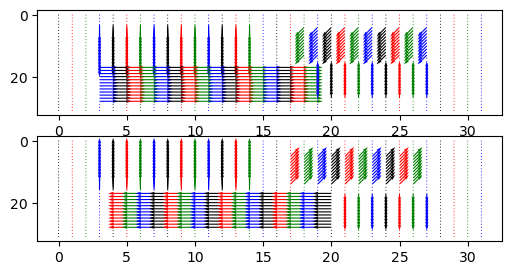

In [363]:
data_inv = [v_primes[i].reshape((nx**2,2)) for i in range(t_end-1)]
data_ = [vs[i].reshape((nx**2,2)) for i in range(t_end-1)]

origin = [np.array(R)[:,1], np.array(R)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), 
# color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(6*(t_end-1),3*(t_end-1)))
if (t_end <=2):
    ax = ax.reshape((-1,1))
for i in range(len(data_)):
    ax[0,i].quiver(*origin, data_[i][:, 1], -data_[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()
    ax[1,i].quiver(*origin, data_inv[i][:, 1], -data_inv[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[1,i].invert_yaxis()


In [329]:

def solve_opt_flow3(u_traj,shape,t_end,v_trues,v_max = 2, n_iter = 60,reduction = False,pnorm=2,qnorm=2,proj_dim=1,**kwargs):
    '''Solves the regularized optical flow equation'''
    if (reduction == True):
        scale = kwargs['scale'] if ('scale' in kwargs) else 2
    else:
        scale = 1

    delta_x = v_max
    delta_y =delta_x
    size =shape[0]
    nx=shape[0];ny=shape[1]
    R = np.array(list(np.ndindex(*shape)))
    kernel_x = np.zeros((2*v_max+1,2*v_max+1))
    kernel_x[:,0] = -1 
    kernel_x[:,-1] = 1 
    kernel_y = kernel_x.T 
    kernel_t = np.ones((2*v_max+1,2*v_max+1))
    u_traj = deepcopy(u_traj)

    u_traj_  = deepcopy(u_traj)
    Ls = []

    for i in range(len(u_traj)-1):

            # Reshape the image array into a 4D array where each element is a 2x2 block
        blocks = u_traj_[i].reshape(nx//scale, scale, ny//scale, scale)

        # Take the mean along the last two axes to get the average of each 2x2 block
        u_traj[i] = np.mean(blocks, axis=(1, 3))

        blocks = u_traj_[i+1].reshape(nx//scale, scale, ny//scale, scale)

        # Take the mean along the last two axes to get the average of each 2x2 block
        u_traj[i+1] = np.mean(blocks, axis=(1, 3))

        shape_ = u_traj[i].shape
        nx_=shape_[0]
        ny_=shape_[1]

        u_traj[i] = u_traj[i].reshape(shape_)
        u_traj[i+1] = u_traj[i+1].reshape(shape_)

        uy = -vec(signal.convolve2d(u_traj[i], kernel_x, boundary='symm', mode='same'))/(delta_x*2*kernel_x.shape[0])
        ux = -vec(signal.convolve2d(u_traj[i], kernel_y, boundary='symm', mode='same'))/(delta_y*2*kernel_y.shape[0])

        if i == 0:
            ut = vec(signal.convolve2d(u_traj[i+1], kernel_t, boundary='symm', mode='same') - signal.convolve2d(u_traj[i], kernel_t, boundary='symm', mode='same'))/(kernel_t.size)
        else: 
            ut = vec(signal.convolve2d(u_traj[i+1], kernel_t, boundary='symm', mode='same') - signal.convolve2d(u_traj[i-1], kernel_t, boundary='symm', mode='same'))/(2*kernel_t.size)
            
        Li = []
        for i in range(nx_*ny_): 
            Li.append((ux[i],uy[i],ut[i]))
        Li = np.array(Li)
        Ls.append(Li)

    L = gen_first_derivative_operator_2D(nx_,ny_)
    # a=np.zeros((L.[0],2*L.[1])) 
    from scipy.sparse import csr_matrix
    a = csr_matrix((L.shape[0],2*L.shape[1]))#.toarray()
    a[:,::2] = L
    # b=np.zeros((L.[0],2*L.shape[1])) 
    b = csr_matrix((L.shape[0],2*L.shape[1]))#.toarray()
    b[:,1::2] = L
    Lv =  sparse.vstack((a,b))

    v_ests = []
    v_larges =[]

    for i in range(len(Ls)):
        if v_trues is not None:
            v_true=v_trues[i].reshape(v_trues[i].size,1)
        else:
            v_true = None
        Lx = Ls[i][:,0];Ly = Ls[i][:,1];Lt = Ls[i][:,2]

        ux_uy = scipy.linalg.block_diag(*[np.array([Lx[i], Ly[i]]) for i in range(nx_*ny_)])
        ut = Lt
        (v_est, info) = MMGKS3(ux_uy, -ut.reshape((len(ut),1)), Lv, pnorm=pnorm, qnorm=qnorm, projection_dim=proj_dim, n_iter=n_iter, regparam='gcv', 
                        x_true=v_true, tqdm_ = False)
        v_est = v_est.reshape(nx_*ny_,2)
        v_large = np.zeros((nx,nx,2))
        block_size = scale
        # Iterate over each 2x2 block
        k=0
        for m in range(0, nx - block_size + 1, block_size):
            for n in range(0, ny - block_size + 1, block_size):
                # Extract the current 2x2 block
                v_large[m:m+block_size, n:n+block_size] = v_est[k]
                k+=1

        #v_est = v_large

        v_est = v_est.reshape((nx_,ny_,2))

        v_large = v_large.reshape((nx,ny,2))*scale

        v_ests.append(v_est)

        v_larges.append(v_large)

    return (v_ests, v_larges, info)

def MMGKS3(A, b, L, pnorm=2, qnorm=1, projection_dim=3, n_iter=5, regparam='gcv', x_true=None, tqdm_ = True, **kwargs):

    dp_stop = kwargs['dp_stop'] if ('dp_stop' in kwargs) else False
    isoTV_option = kwargs['isoTV'] if ('isoTV' in kwargs) else False
    GS_option = kwargs['GS'] if ('GS' in kwargs) else False
    epsilon = kwargs['epsilon'] if ('epsilon' in kwargs) else 0.1
    prob_dims = kwargs['prob_dims'] if ('prob_dims' in kwargs) else False
    regparam_sequence = kwargs['regparam_sequence'] if ('regparam_sequence' in kwargs) else [0.1*(0.5**(x)) for x in range(0,n_iter)]
    (U, B, V) = golub_kahan_2(A, b, projection_dim, dp_stop,tqdm_, **kwargs)
    
    x_history = []
    lambda_history = []
    residual_history = []
    e = 1
    x = A.T @ b # initialize x for reweighting
    AV = A@V
    LV = L@V
    if (tqdm_ == True):
        range_ = tqdm(range(n_iter), desc='running MMGKS...')
    else:
        range_ = range(n_iter)
    for ii in range_:
        # compute reweighting for p-norm approximation
        v = A @ x - b
        wf = ((v**2 + epsilon**2)**(pnorm/2 - 1))**(1/2)
        AA = AV*wf
        (Q_A, R_A) = la.qr(AA, mode='economic') # Project A into V, separate into Q and R
        u = L @ x
        if isoTV_option in ['isoTV', 'ISOTV', 'IsoTV']:
            if prob_dims == False:
                raise TypeError("For Isotropic TV you must enter the dimension of the dynamic problem! Example: (x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =3, regparam = 0.005, x_true = None, isoTV = 'isoTV', prob_dims = (nx,ny, nt))")
            else:
                nx = prob_dims[0]
                ny = prob_dims[1]
            nt = int((x.reshape((-1,1)).shape[0])/(nx*ny))
            Ls = gen_first_derivative_operator_2D(nx, ny)
            spacen = int(Ls.shape[0] / 2)
            spacent = spacen * nt
            X = x.reshape(nx**2, nt)
            LsX = Ls @ X
            LsX1 = LsX[:spacen, :]
            LsX2 = LsX[spacen:2*spacen, :]
            weightx = (LsX1**2 + LsX2**2 + epsilon**2)**((qnorm-2) / 4)
            weightx = np.concatenate((weightx.flatten(), weightx.flatten()))
            weightt = (u[2*spacent:]**2 + epsilon**2)**((qnorm-2) / 4)
            wr = np.concatenate((weightx.reshape(-1,1), weightt))
        elif GS_option in  ['GS', 'gs', 'Gs']:
            if prob_dims == False:
                raise TypeError("For Isotropic TV you must enter the dimension of the dynamic problem. (x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =3, regparam = 0.005, x_true = None, isoTV = 'isoTV', prob_dims = (nx,ny, nt))")
            else:
                nx = prob_dims[0]
                ny = prob_dims[1]
            wr = GS_weights(x, nx, ny, epsilon, qnorm)
        else:
            wr = (smoothed_holder_weights(u, epsilon=epsilon, p=qnorm).reshape((-1,1)))**(1/2)
        # q = sparse.spdiags(data = z.flatten() , diags=0, m=z.shape[0], n=z.shape[0])
        # temp = q @ (L @ V)
        # wr = (u**2 + epsilon**2)**(qnorm/2 - 1)
        LL = LV * wr
        (Q_L, R_L) = la.qr(LL, mode='economic') # Project L into V, separate into Q and R
       
        if regparam == 'gcv':
            lambdah = generalized_crossvalidation_2(Q_A, R_A, R_L, wf*b, **kwargs)#['x'].item() # find ideal lambda by crossvalidation
        elif regparam == 'dp':
            lambdah = discrepancy_principle(Q_A, R_A, R_L, wf*b, **kwargs)#['x'].item() # find ideal lambdas by crossvalidation

        else:
            lambdah = regparam
        
        lambda_history.append(lambdah)
        y,_,_,_ = np.linalg.lstsq(np.concatenate((R_A, np.sqrt(lambdah) * R_L)), np.concatenate((Q_A.T@ (wf* b), np.zeros((R_L.shape[0],1)))),rcond=None)
        x = V @ y # project y back
        x_history.append(x)
        if ii >= R_L.shape[0]:
            break
        v = AV@y
        v = v - b
        u = LV @ y
        ra = (wf**2) * (AV @ y - b)
        ra = A.T @ ra
        rb = (wr**2) * (LV @ y)
        rb = L.T @ rb
        r = ra + lambdah * rb
        r = r - V @ (V.T @ r)
        r = r - V @ (V.T @ r)
        normed_r = r / la.norm(r) # normalize residual
        vn = r / np.linalg.norm(r)
        V = np.column_stack((V, vn))
        Avn = A @ vn
        AV = np.column_stack((AV, Avn))
        #print(L.shape,vn.shape,A.shape)
        Lvn = vn
        Lvn = L@vn
        LV = np.column_stack((LV, Lvn))
        residual_history.append(la.norm(r))
        
    if x_true is not None:
        x_true_norm = la.norm(x_true)
        rre_history = [la.norm(x - x_true)/x_true_norm for x in x_history]
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'relError': rre_history, 'Residual': residual_history, 'its': ii}
    else:
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'Residual': residual_history, 'its': ii}
    
    return (x, info)
def golub_kahan_2(A, b, n_iter, dp_stop=False, tqdm_=True, **kwargs):
    """
    Description: Computes the Golub-Kahan factorization of A, with initial guess the given vector b.

    Inputs:
    A: the matrix to be factorized.

    b: an initial guess for the first basis vector of the factorization.

    n_iter: the number of iterations over which to factorize A.

    dp_stop: whether or not to use the discrepancy principle to halt further factorization. Defaults to false.

    Outputs:
    U (m x n_iter+1) an orthonormal matrix

    V (n x n_iter) an orthonormal matrix

    S (n_iter+1 x n_iter) a bidiagonal matrix.
    
    Calling with the minimal number of arguments:

    (U,S,V) = generalized_golub_kahan(A, b, n_iter)

    Calling with all the arguments necessary for discrepancy principle stopping:

    (U,S,V) = generalized_golub_kahan(A, b, n_iter, dp_stop=True, gk_eta=1.001, gk_delta=0.001)
    
    """

    eta = kwargs['gk_eta'] if ('gk_eta' in kwargs) else 1.001
    delta = kwargs['gk_delta'] if ('gk_delta' in kwargs) else 0.001

    (rows, cols) = A.shape

    betas = np.zeros(shape=(1)) # start the set of alphas and betas in the bidiagonal matrix
    alphas = np.zeros(shape=(1)) # return matrix instead of arrays

    U = np.zeros((rows, 1+1)) # start the bases at dimension of iter and iter+1
    V = np.zeros((cols, 1))

    U[:,0] = (b/np.linalg.norm(b)).flatten()#reshape((-1,1)) # initialize U with the normalized guess
                                       
    iterations = 0
                                       
    res_norm = np.inf # set for the while condition
    if (tqdm_ == True):
        range_ = tqdm(range(n_iter), desc='generating basis...')
    else:
        range_ = range(n_iter)
    for ii in range_:                                   

        if ((dp_stop == True) and (res_norm <= eta*delta)):
            print("discrepancy principle satisfied, halting early.")
            break
        
        if iterations != 0:
            U = np.pad(U, ((0,0), (0,1)) )  # at each iteration that doesn't satisfy the discrepancy principle,
            V = np.pad(V, ((0,0), (0,1)) )  # add an additional column to the bases and entry to the bidiagonal entries.
            betas = np.pad(betas, ((0,1)) )
            alphas = np.pad(alphas, ((0,1)) )

        V[:,iterations] = A.T @ U[:,iterations] - betas[iterations-1] * V[:,iterations-1] # perform bidiagonalization as before
        alphas[iterations] = np.linalg.norm(V[:,iterations])
        V[:,iterations] = V[:,iterations]/alphas[iterations]

        U[:,iterations+1] = A @ V[:,iterations] - alphas[iterations] * U[:,iterations]
        betas[iterations] = np.linalg.norm(U[:,iterations+1])
        U[:,iterations+1] = U[:,iterations+1]/betas[iterations]

        if (dp_stop == True):
                                       
            S = np.pad(np.diag(alphas),( (0,1),(0,0) )) + np.pad(np.diag(betas), ( (1,0),(0,0) ) ) # constrct B from the bidiagonal entries
                                        
            bhat = U.T @ b
                                        
            y = np.linalg.lstsq(S, bhat, rcond=None)[0] # solve the least squares problem
            
            x = V @ y # project back
                                        
            res_norm = np.linalg.norm(A @ x - b) # and find the norm of the residual
                                       
        iterations += 1


    S = np.zeros(shape=(alphas.shape[0]+1, alphas.shape[0]) )
    S[range(0,alphas.shape[0]), range(0,alphas.shape[0])] = alphas
    S[range(1,alphas.shape[0]+1), range(0,alphas.shape[0])] = betas


    return (U,S,V)
def gcv_numerator_2(reg_param, Q_A, R_A, R_L, b,**kwargs):
    variant = kwargs['variant'] if ('variant' in kwargs) else 'standard'

    # the observation term:

    R_A_2 = R_A.T @ R_A

    R_A_2 = R_A_2.todense() if isinstance(R_A_2, LinearOperator) else R_A_2

    # The regularizer term:

    R_L_2 = (R_L.T @ R_L)
    
    R_L_2 = R_L_2.todense() if isinstance(R_L_2, LinearOperator) else R_L_2

    # the inverse term:

    inverted = np.linalg.lstsq(( R_A_2 + reg_param * R_L_2), (R_A.T @ Q_A.T @ b) ,rcond=None)[0]  # la.solve( ( R_A_2 + reg_param * R_L_2), (R_A.T @ Q_A.T @ b) )

    if variant == 'modified':
        return ((np.linalg.norm( R_A @ inverted - Q_A.T @ b ))**2 + np.linalg.norm(b - Q_A@(Q_A.T@b))**2)
    else:
        return (np.linalg.norm( R_A @ inverted - Q_A.T @ b ))**2

        # return np.sqrt((np.linalg.norm( R_A @ inverted - Q_A.T @ b ))**2 + np.linalg.norm(b - Q_A@(Q_A.T@b))**2)

def gcv_denominator_2(reg_param, R_A, R_L, b, **kwargs):

    variant = kwargs['variant'] if ('variant' in kwargs) else 'standard'
    # print(variant)
    # the observation term:

    R_A_2 = R_A.T @ R_A

    R_A_2 = R_A_2.todense() if isinstance(R_A_2, LinearOperator) else R_A_2

    # The regularizer term:

    R_L_2 = (R_L.T @ R_L)

    R_L_2 = R_L_2.todense() if isinstance(R_L_2, LinearOperator) else R_L_2

    inverted = np.linalg.lstsq(( R_A_2 + reg_param * R_L_2), R_A.T,rcond=None)[0]  #la.solve( ( R_A_2 + reg_param * R_L_2), R_A.T )

    if variant == 'modified':
       m = kwargs['fullsize']
       trace_term = (m - R_A.shape[1]) - np.trace(R_A @ inverted) # b.size - np.trace(R_A @ inverted) # this is defined with respect to the projected quantities 
    else:
        # in this way works even if we revert to the fully projected pb (call with Q_A.T@b)
        # trace_term = b.size - np.trace(R_A @ inverted) # this is defined with respect to the projected quantities
        trace_term = R_A.shape[0]- np.trace(R_A @ inverted)
    return trace_term**2

def generalized_crossvalidation_2(Q_A, R_A, R_L, b, **kwargs):

    if 'tol' in kwargs:
        tol = kwargs['tol']
    else:
        tol = 10**(-12)

    # function to minimize
    gcv_func = lambda reg_param: gcv_numerator_2(reg_param, Q_A, R_A, R_L, b) / gcv_denominator_2(reg_param, R_A, R_L, b, **kwargs)
    lambdah = op.fminbound(func = gcv_func, x1 = 1e-9, x2 = 100, args=(), xtol=1e-12, maxfun=1000, full_output=0, disp=0)
    
    return lambdah

In [35]:
n_iter = 20
v_av = v_max#math.ceil((v_min+v_max)/2)
scale = 2
if (scale ==1): 
    v_trues = vs
else: 
    v_trues = None
v_ests_,v_larges_,info_v_b  = solve_opt_flow(u_traj,shape=shape,t_end=t_end,v_trues = v_trues,v_max=v_av, n_iter = n_iter,reduction=True,scale=scale,pnorm= 2, qnorm=2,proj_dim=10)

nx_= nx//scale; ny_=nx_
# v_ests= v_ests_ * np.sqrt(scale)
# v_larges = v_larges_ * scale
v_ests = []; v_larges =[]
for v in v_ests_:
    v = v.reshape(nx_,nx_,2)
    v = v*(scale)
    v[0,:] = np.zeros(2); v[:,0] = np.zeros(2); v[:,nx_-1] = np.zeros(2); v[nx_-1,:] = np.zeros(2)
    v_ests.append(v)
for v in v_larges_:
    v = v.reshape(nx,ny,2)
    v = v#*(scale)
    v[0,:] = np.zeros(2); v[:,0] = np.zeros(2); v[:,nx-1] = np.zeros(2); v[nx-1,:] = np.zeros(2)
    v_larges.append(v)

# v_ests[v_ests>v_max] = v_max
# v_ests[v_ests<-v_max] = -v_max

v_ests_b = [np.rint(v_ests[(len(v_ests)//(t_end-1))*t:(len(v_ests)//(t_end-1)*(t+1))]) for t in range(t_end-1)]
v_ests_c = [np.rint(v_larges[(len(v_larges)//(t_end-1))*t:(len(v_larges_)//(t_end-1)*(t+1))]) for t in range(t_end-1)]



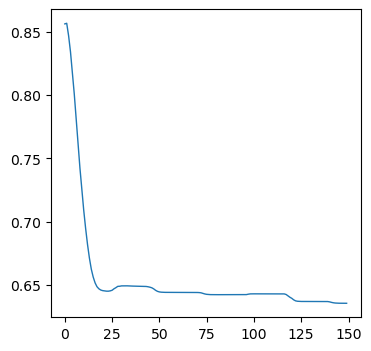

In [11]:
plt.figure(figsize=(4,4))
plt.plot(info_v_b['relError'],'-',lw=1)

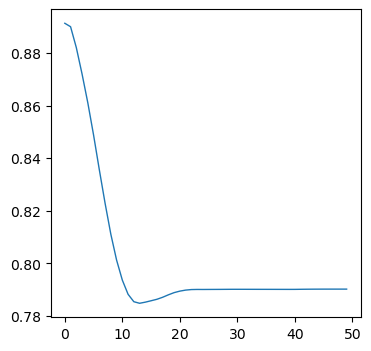

In [365]:
plt.figure(figsize=(4,4))
plt.plot(info_v_b['relError'],'-',lw=1)

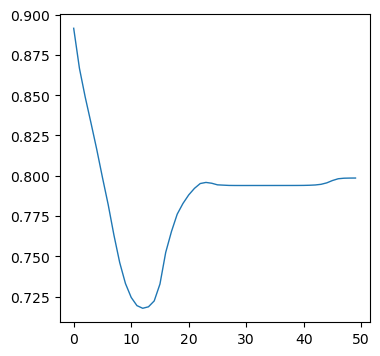

In [367]:
plt.figure(figsize=(4,4))
plt.plot(info_v_b['relError'],'-',lw=1)

In [340]:
n_iter = 10
v_av = v_max#math.ceil((v_min+v_max)/2)
scale = 1
if (scale ==1): 
    v_trues = vs
else: 
    v_trues = None
v_ests_,v_larges_,info_v_b  = solve_opt_flow3(u_traj,shape=shape,t_end=t_end,v_trues = v_trues,v_max=v_av, n_iter = n_iter,reduction=True,scale=scale,pnorm= 2, qnorm=1,proj_dim=10)

nx_= nx//scale; ny_=nx_
# v_ests= v_ests_ * np.sqrt(scale)
# v_larges = v_larges_ * scale
v_ests = []; v_larges =[]
for v in v_ests_:
    v = v.reshape(nx_,nx_,2)
    v = v*(scale)
    v[0,:] = np.zeros(2); v[:,0] = np.zeros(2); v[:,nx_-1] = np.zeros(2); v[nx_-1,:] = np.zeros(2)
    v_ests.append(v)
for v in v_larges_:
    v = v.reshape(nx,ny,2)
    v = v#*(scale)
    v[0,:] = np.zeros(2); v[:,0] = np.zeros(2); v[:,nx-1] = np.zeros(2); v[nx-1,:] = np.zeros(2)
    v_larges.append(v)

# v_ests[v_ests>v_max] = v_max
# v_ests[v_ests<-v_max] = -v_max

v_ests_b = [np.rint(v_ests[(len(v_ests)//(t_end-1))*t:(len(v_ests)//(t_end-1)*(t+1))]) for t in range(t_end-1)]
v_ests_c = [np.rint(v_larges[(len(v_larges)//(t_end-1))*t:(len(v_larges_)//(t_end-1)*(t+1))]) for t in range(t_end-1)]



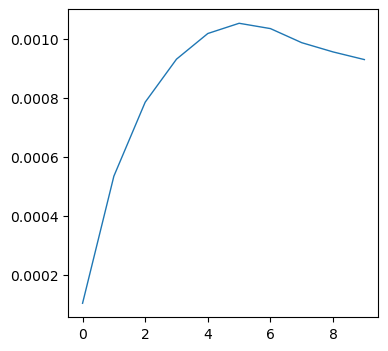

In [341]:
plt.figure(figsize=(4,4))
plt.plot(info_v_b['regParam_history'],'-',lw=1)


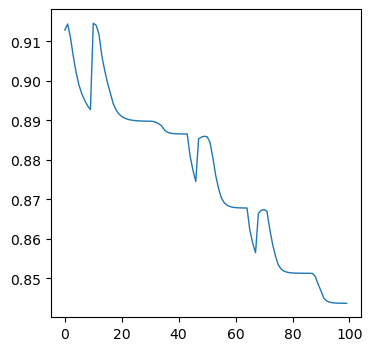

In [106]:
plt.figure(figsize=(4,4))
plt.plot(info_v_b['relError'],'-',lw=1)

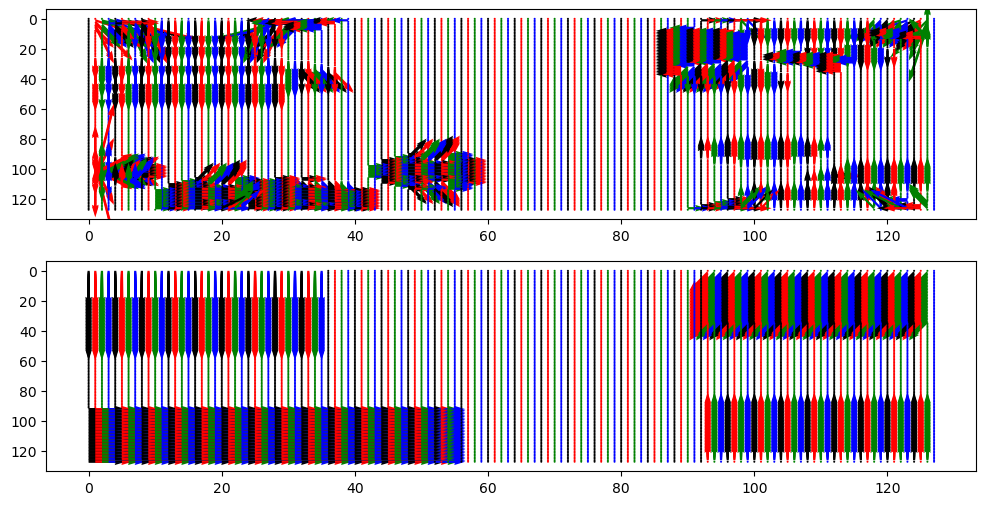

In [29]:
# nx_=64
data_inv = [vs[i].reshape((nx**2,2)) for i in range(t_end-1)]
data_ = [(v_ests_c[i]).reshape((nx**2,2)) for i in range(t_end-1)]

origin = [np.array(R)[:,1], np.array(R)[:,0]]

R_ = np.array(list(np.ndindex(*(nx_,nx_))))
origin_ = [np.array(R_)[:,1], np.array(R_)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), 
# color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(6*2*(t_end-1),3*2*(t_end-1)))
if (t_end <=2):
    ax = ax.reshape((-1,1))
for i in range(len(data_)):
    ax[0,i].quiver(*origin, data_[i][:, 1], -data_[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()
    ax[1,i].invert_yaxis()
    ax[1,i].quiver(*origin, data_inv[i][:, 1], -data_inv[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)


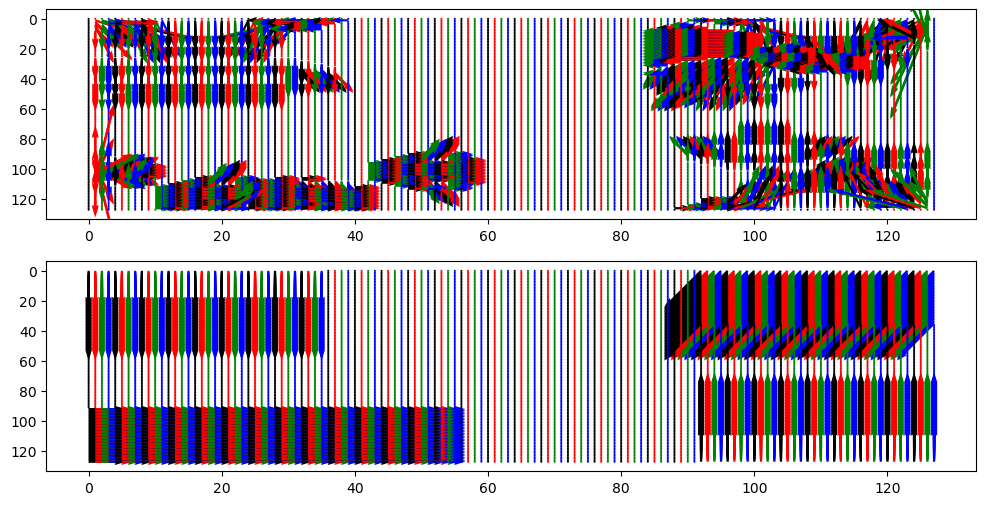

In [33]:
# nx_=64
data_inv = [vs[i].reshape((nx**2,2)) for i in range(t_end-1)]
data_ = [(v_ests_c[i]).reshape((nx**2,2)) for i in range(t_end-1)]

origin = [np.array(R)[:,1], np.array(R)[:,0]]

R_ = np.array(list(np.ndindex(*(nx_,nx_))))
origin_ = [np.array(R_)[:,1], np.array(R_)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), 
# color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(6*2*(t_end-1),3*2*(t_end-1)))
if (t_end <=2):
    ax = ax.reshape((-1,1))
for i in range(len(data_)):
    ax[0,i].quiver(*origin, data_[i][:, 1], -data_[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()
    ax[1,i].invert_yaxis()
    ax[1,i].quiver(*origin, data_inv[i][:, 1], -data_inv[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)


0.2248661611336028 0.8388000959150097


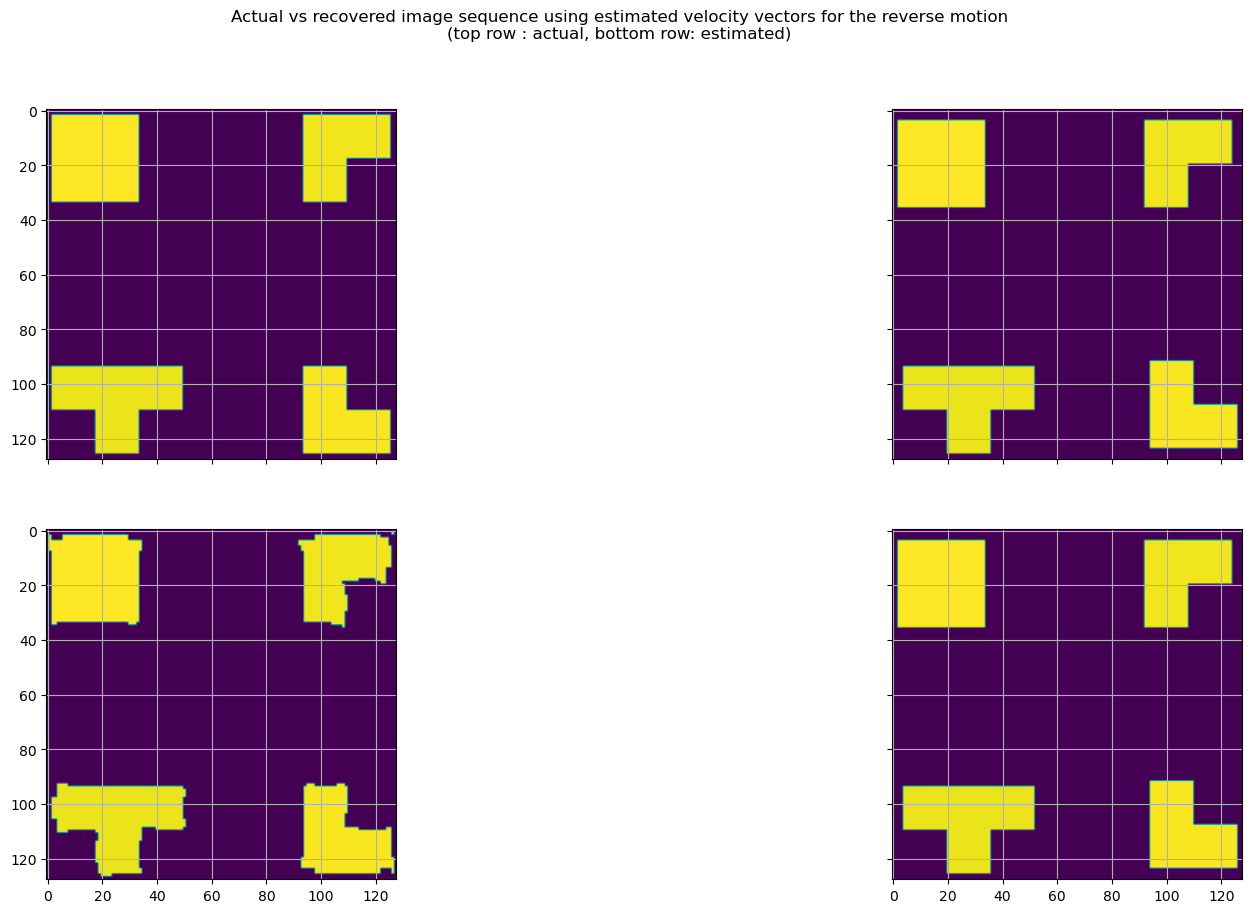

In [34]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i])

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i]-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');

0.24418833420553018 0.8827202339007918


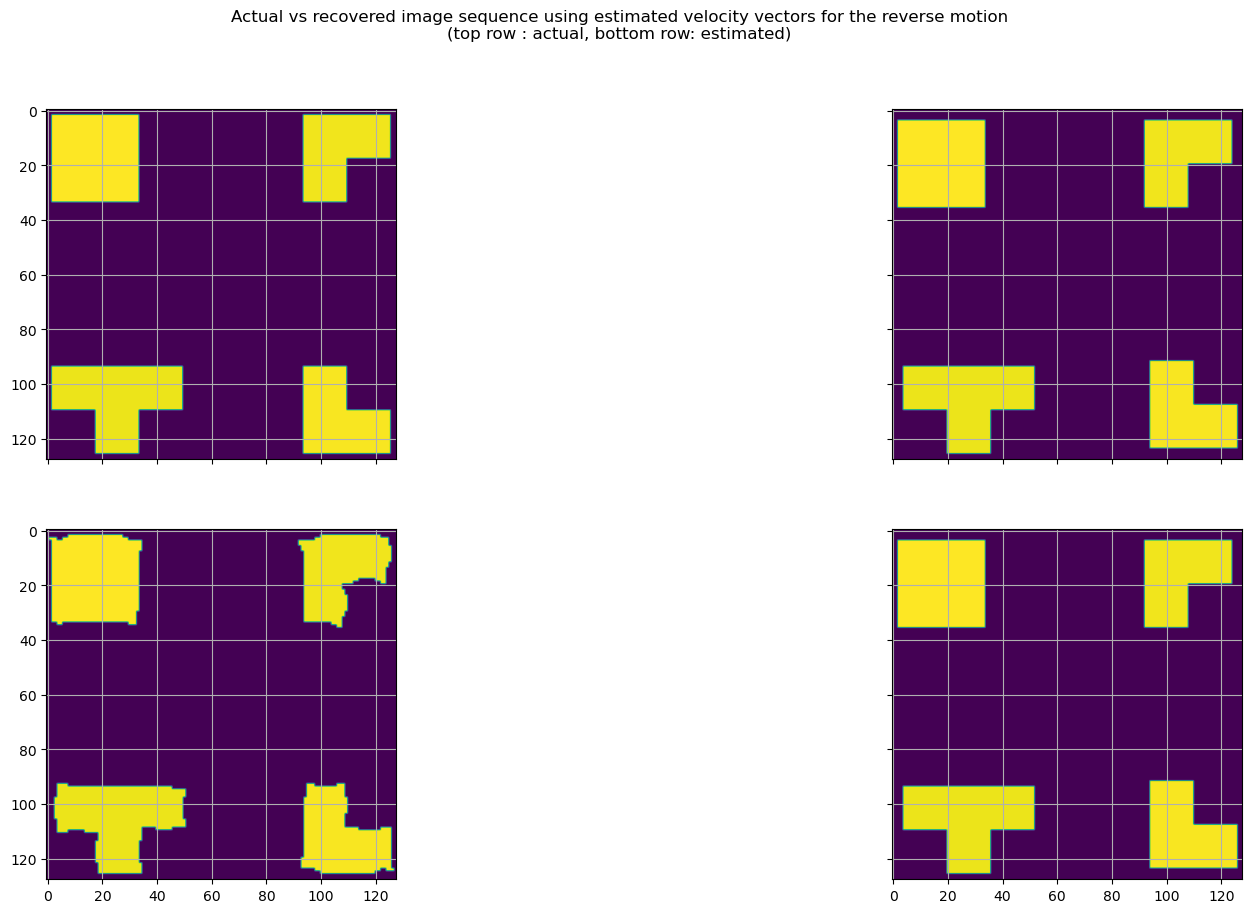

In [36]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i])

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i]-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');

0.9410903146527849 3.098533044761417
0.9287088480332624 2.528522105159688
0.8930529813843502 2.494438257849294
0.90241683204083 3.4791246585919673


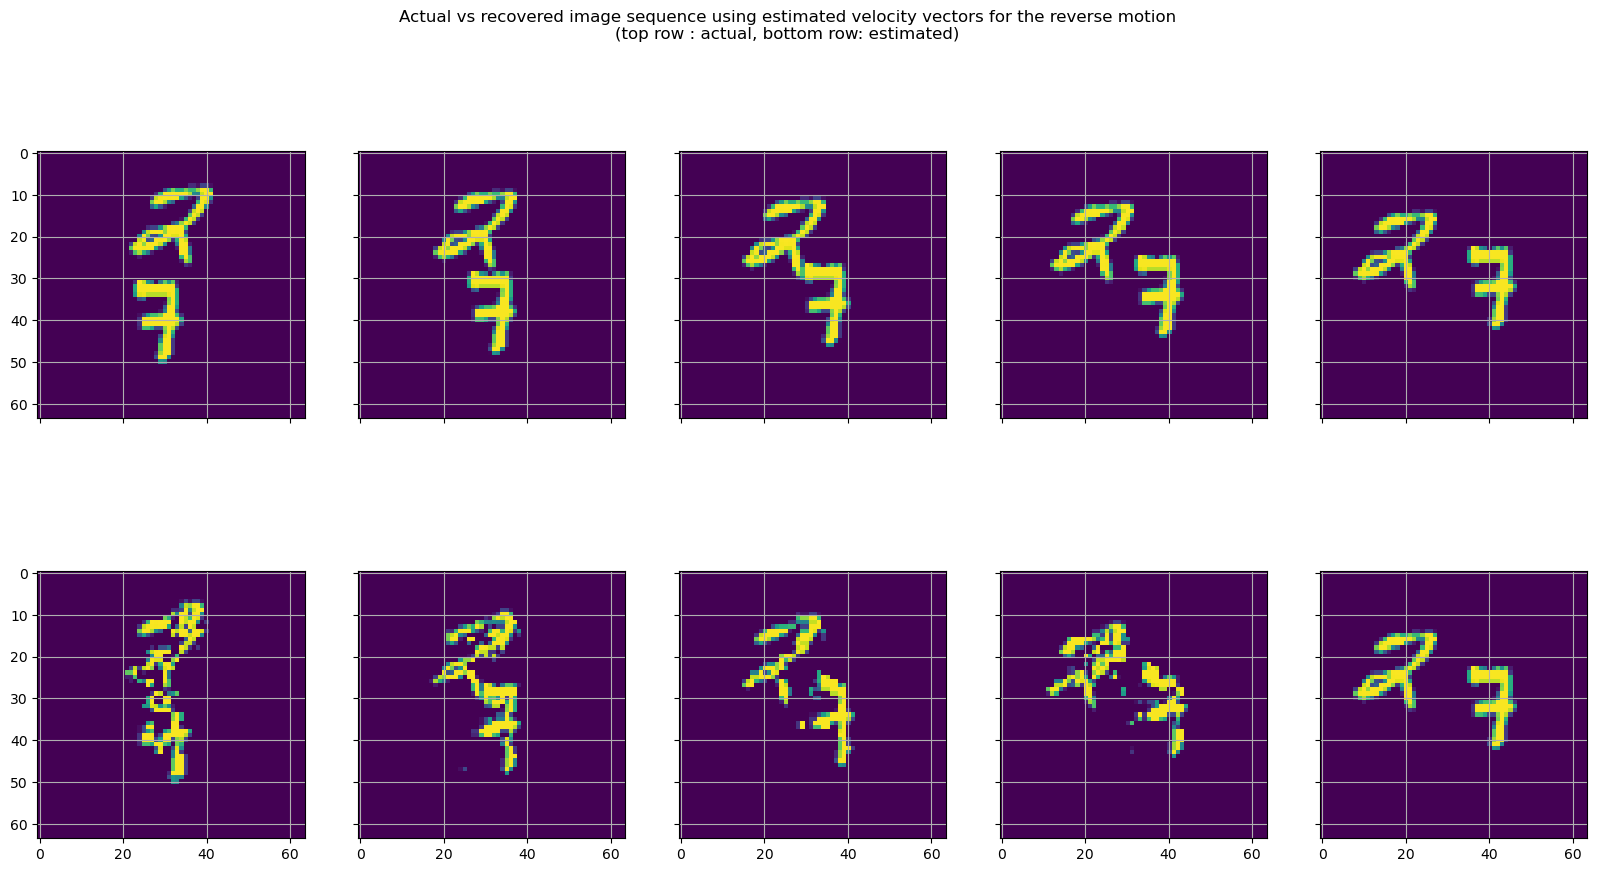

In [266]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = u_inv_traj #[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i].reshape(shape))

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i].reshape(shape)-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');



0.8750908500611863 7.44252352784894


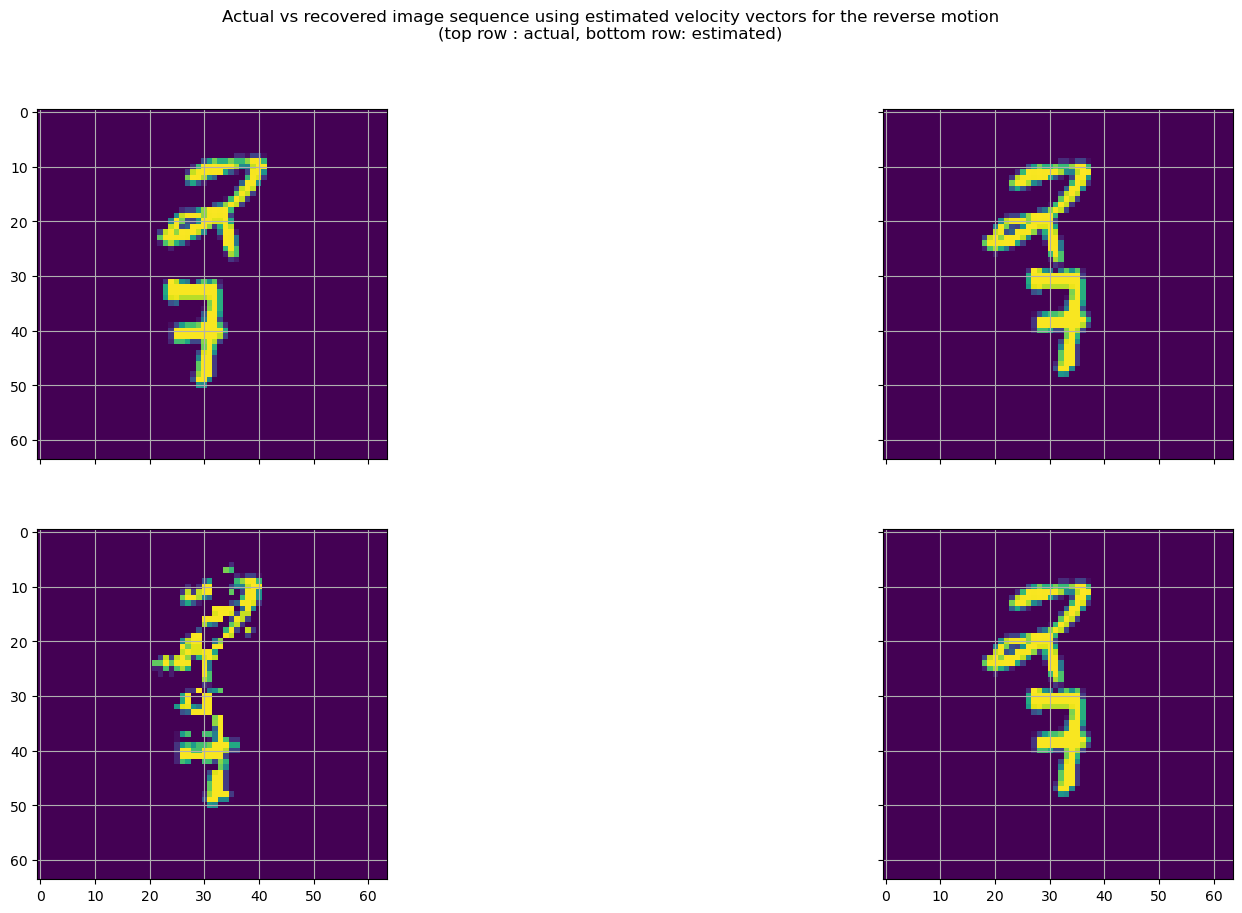

In [248]:
fig,ax=plt.subplots(2,t_end,figsize=(20,10),sharex=True, sharey=True)
vel_shape = shape[0],shape[1],2
#u_traj.reverse()
rec = [u_inv_traj[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),(v_ests_c[::-1][i]).reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
rec = rec[::-1]
orig = u_inv_traj #[0].reshape(shape)] + [M(u_inv_traj[i].reshape(shape),vs[::-1][i].reshape(vel_shape)).reshape(shape) for i in range(t_end - 1)]
orig = orig[::-1]
for i in range(0,t_end):
    ax[1,i].imshow(rec[i])
    ax[0,i].imshow(orig[i].reshape(shape))

    ax[1,i].grid('minor')
    ax[0,i].grid('minor')
    if (i<t_end-1):
        print(np.linalg.norm(orig[i].reshape(shape)-rec[i])/np.linalg.norm(orig[i]),np.linalg.norm(vs[i]-v_ests_c[::-1][i].reshape(vel_shape))/np.linalg.norm(vs[i]))

fig.suptitle('Actual vs recovered image sequence using estimated velocity vectors for the reverse motion' + '\n' + '(top row : actual, bottom row: estimated)');